In [1]:
import pandas as pd
import numpy as np

import torch
import numpy as np
import pandas as pd
import pickle
import multiprocessing
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


def get_cv_idxs(n, cv_idx=0, val_pct=0.2, seed=42):
    """ Get a list of index values for Validation set from a dataset

    Arguments:
        n : int, Total number of elements in the data set.
        cv_idx : int, starting index [idx_start = cv_idx*int(val_pct*n)]
        val_pct : (int, float), validation set percentage
        seed : seed value for RandomState

    Returns:
        list of indexes
    """
    np.random.seed(seed)
    n_val = int(val_pct * n)
    idx_start = cv_idx * n_val
    idxs = np.random.permutation(n)
    return idxs[idx_start:idx_start + n_val]


def split_by_idx(idxs, *a):
    """
    Split each array passed as *a, to a pair of arrays like this (elements selected by idxs,  the remaining elements)
    This can be used to split multiple arrays containing training data to validation and training set.

    :param idxs [int]: list of indexes selected
    :param a list: list of np.array, each array should have same amount of elements in the first dimension
    :return: list of tuples, each containing a split of corresponding array from *a.
            First element of each tuple is an array composed from elements selected by idxs,
            second element is an array of remaining elements.
    """
    mask = np.zeros(len(a[0]), dtype=bool)
    mask[np.array(idxs)] = True
    return [(o[mask], o[~mask]) for o in a]


class AutoEncoder(object):

    def __init__(self, data, validation_perc=0.2, lr=0.001,
                 intermediate_size=1000, encoded_size=100):

        # create training dataloader and validation tensor
        self.data = data
        self.val_idxs = get_cv_idxs(n=data.shape[0], val_pct=validation_perc)
        [(self.val, self.train)] = split_by_idx(self.val_idxs, data)
        self.dataset = AETrainingData(self.train)
        self.dataloader = DataLoader(self.dataset, batch_size=64, shuffle=True,
                                     num_workers=multiprocessing.cpu_count())
        #print('datal=',self.dataloader)
        self.val = torch.from_numpy(self.val.values).\
            type(torch.FloatTensor).cuda()

        # instantiate the encoder and decoder nets
        size = data.shape[1]
        self.encoder = Encoder(size, intermediate_size, encoded_size).cuda()
        self.decoder = Decoder(size, intermediate_size, encoded_size).cuda()

        # instantiate the optimizers
        self.encoder_optimizer = optim.Adam(
            self.encoder.parameters(), lr=lr, weight_decay=1e-8)
        self.decoder_optimizer = optim.Adam(
            self.decoder.parameters(), lr=lr, weight_decay=1e-8)

        # instantiate the loss criterion
        self.criterion = nn.MSELoss(reduction='mean')

        self.train_losses = []
        self.val_losses = []

    def train_step(self, input_tensor, target_tensor):
        # clear the gradients in the optimizers
        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()

        # Forward pass through
        encoded_representation = self.encoder(input_tensor)
        reconstruction = self.decoder(encoded_representation)

        # Compute the loss
        loss = self.criterion(reconstruction, target_tensor)

        # Compute the gradients
        loss.backward()

        # Step the optimizers to update the model weights
        self.encoder_optimizer.step()
        self.decoder_optimizer.step()

        # Return the loss value to track training progress
        return loss.item()
    
    def reset(self, train=True):
        # due to dropout the network behaves differently in training and
        # evaluation modes
        if train: self.encoder.train(); self.decoder.train()
        else: self.encoder.eval(); self.decoder.eval()

    def get_val_loss(self, input_tensor, target_tensor):
        self.reset(train=False)
        encoded = self.encoder(input_tensor)
        decoded = self.decoder(encoded)
        loss = self.criterion(decoded, target_tensor)
        return loss.item()

    def train_loop(self, epochs, print_every_n_batches=20):

        # Cycle through epochs
        for epoch in range(epochs):
            print(f'Epoch {epoch + 1}/{epochs}')

            # Cycle through batches
            for i, batch in enumerate(self.dataloader):
                #print(i,batch)
                
                self.reset(train=True)

                input_tensor = batch['input'].cuda()
                target_tensor = batch['target'].cuda()

                loss = self.train_step(input_tensor, target_tensor)

                if i % print_every_n_batches == 0 and i != 0:
                    #print('i=',i)
                    val_loss = self.get_val_loss(self.val, self.val)
                    print(f'train loss: {round(loss, 8)} | ' +
                          f'validation loss: {round(val_loss, 8)}')
                    self.train_losses.append(loss)
                    self.val_losses.append(val_loss)

    def get_encoded_representations(self):
        to_encode = torch.from_numpy(self.data.values).type(
            torch.FloatTensor).cuda()
        self.reset(train=False)
        encodings = self.encoder(to_encode).cpu().data.numpy()
        return encodings


class AETrainingData(Dataset):
    """
    Format the training dataset to be input into the auto encoder.
    Takes in dataframe and converts it to a PyTorch Tensor
    """

    def __init__(self, x_train):
        self.x = x_train

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        """
        Returns a example from the data set as a pytorch tensor.
        """
        # Get example/target pair at idx as numpy arrays
        x, y = self.x.iloc[idx].values, self.x.iloc[idx].values

        # Convert to torch tensor
        x = torch.from_numpy(x).type(torch.FloatTensor)
        y = torch.from_numpy(y).type(torch.FloatTensor)

        # Return pair
        return {'input': x, 'target': y}


class Encoder(nn.Module):
    def __init__(self, input_size, intermediate_size, encoding_size):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, intermediate_size),
            nn.BatchNorm1d(intermediate_size),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(intermediate_size, encoding_size),
            nn.BatchNorm1d(encoding_size),
            nn.ReLU(True),
            nn.Dropout(0.2))

    def forward(self, x):
        x = self.encoder(x)
        return x


class Decoder(nn.Module):
    def __init__(self, output_size, intermediate_size, encoding_size):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Linear(encoding_size, intermediate_size),
            nn.BatchNorm1d(intermediate_size),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(intermediate_size, output_size),
            nn.BatchNorm1d(output_size),
            nn.Sigmoid())

    def forward(self, x):
        x = self.decoder(x)
        return x


In [4]:
with open(f'new_df_matrix.pkl', 'rb') as fh:
    new_df1 = pickle.load(fh)

In [5]:
ndf=new_df1

In [6]:
ndf=ndf.apply(lambda x: x/x.max(), axis=0)

In [7]:
with open(f'tfidf_matrix.pkl', 'rb') as fh:
    tfidf_df1 = pickle.load(fh)

In [8]:
ndf=ndf.astype(np.float32)
ndf.dtypes

0        float32
1        float32
2        float32
3        float32
4        float32
          ...   
69873    float32
69874    float32
69875    float32
69876    float32
69877    float32
Length: 69878, dtype: object

In [9]:
tfidf_df1=tfidf_df1.astype(np.float32)
tfidf_df1.dtypes

0       float32
1       float32
2       float32
3       float32
4       float32
         ...   
6245    float32
6246    float32
6247    float32
6248    float32
6249    float32
Length: 6250, dtype: object

In [10]:
df_new = pd.concat([ndf, tfidf_df1], axis=1)

In [7]:
df_new.shape

(10677, 76128)

In [8]:
ndf.shape

(10677, 69878)

In [9]:
tfidf_df1.shape

(10677, 6250)

In [13]:
ae_1 = AutoEncoder(df_new, validation_perc=0.1, lr=1e-3, intermediate_size=1000, encoded_size=100)

In [14]:
ae_1.train_loop(epochs=100)

Epoch 1/100
train loss: 0.22646828 | validation loss: 0.23503129
train loss: 0.22065391 | validation loss: 0.21594258
train loss: 0.21307196 | validation loss: 0.20262966
train loss: 0.20799197 | validation loss: 0.19725658
train loss: 0.2080341 | validation loss: 0.20119549
train loss: 0.20572947 | validation loss: 0.19951518
train loss: 0.19499739 | validation loss: 0.19331014
Epoch 2/100
train loss: 0.18429087 | validation loss: 0.17570373
train loss: 0.18372478 | validation loss: 0.17426759
train loss: 0.1862165 | validation loss: 0.16731024
train loss: 0.18219544 | validation loss: 0.16120487
train loss: 0.17845634 | validation loss: 0.16109593
train loss: 0.17349663 | validation loss: 0.17318565
train loss: 0.16278948 | validation loss: 0.15721422
Epoch 3/100
train loss: 0.15996629 | validation loss: 0.1490335
train loss: 0.15556537 | validation loss: 0.14511812
train loss: 0.15418683 | validation loss: 0.14615913
train loss: 0.14689085 | validation loss: 0.13781169
train loss: 0

In [20]:
ae_1.train_loop(epochs=50)

Epoch 1/50
train loss: 0.00457439 | validation loss: 0.00565311
train loss: 0.00525392 | validation loss: 0.00563012
train loss: 0.00495279 | validation loss: 0.00561453
train loss: 0.00434748 | validation loss: 0.00570048
train loss: 0.00528799 | validation loss: 0.00559775
train loss: 0.00446374 | validation loss: 0.00561408
train loss: 0.00430169 | validation loss: 0.00567095
Epoch 2/50
train loss: 0.00708935 | validation loss: 0.00566531
train loss: 0.00435743 | validation loss: 0.00563964
train loss: 0.00402434 | validation loss: 0.00560948
train loss: 0.00571084 | validation loss: 0.00566217
train loss: 0.00448714 | validation loss: 0.00567988
train loss: 0.00674863 | validation loss: 0.00566965
train loss: 0.0067034 | validation loss: 0.00565428
Epoch 3/50
train loss: 0.00452256 | validation loss: 0.0056806
train loss: 0.00348999 | validation loss: 0.00563541
train loss: 0.00503562 | validation loss: 0.00567615
train loss: 0.00630369 | validation loss: 0.00562941
train loss: 0.0

In [15]:
losses_1 = pd.DataFrame(data=list(zip(ae_1.train_losses, ae_1.val_losses)), columns=['train_loss', 'validation_loss'])
losses_1['epoch'] = (losses_1.index + 1) / 3

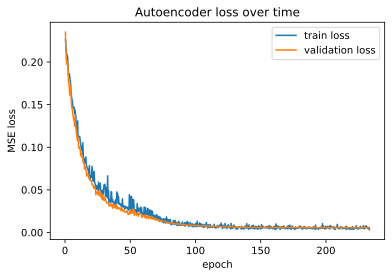

In [27]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'
fig, ax = plt.subplots()
ax.plot(losses_1['epoch'], losses_1['train_loss'], label='train loss')
ax.plot(losses_1['epoch'], losses_1['validation_loss'], label='validation loss')
ax.set_ylabel('MSE loss')
ax.set_xlabel('epoch')
ax.set_title('Autoencoder loss over time')
ax.legend()

In [18]:
encoded_01 = ae_1.get_encoded_representations()

In [19]:
with open('autoencoderhy_embeddings.pkl', 'wb') as fh:
    pickle.dump(encoded_01, fh)

In [17]:
losses_1.to_csv('hyb_loss_1.csv')

In [23]:
losses_2 = pd.DataFrame(data=list(zip(ae_1.train_losses, ae_1.val_losses)), columns=['train_loss', 'validation_loss'])
losses_2['epoch'] = (losses_2.index + 1) / 3

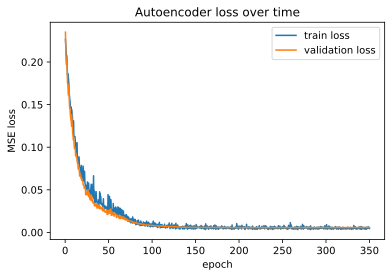

In [24]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'
fig, ax = plt.subplots()
ax.plot(losses_2['epoch'], losses_2['train_loss'], label='train loss')
ax.plot(losses_2['epoch'], losses_2['validation_loss'], label='validation loss')
ax.set_ylabel('MSE loss')
ax.set_xlabel('epoch')
ax.set_title('Autoencoder loss over time')
ax.legend()

In [25]:
encoded_02 = ae_1.get_encoded_representations()

In [26]:
with open('autoencoderhy2_embeddings.pkl', 'wb') as fh:
    pickle.dump(encoded_02, fh)

In [16]:
ae_5 = AutoEncoder(df_new, validation_perc=0.1, lr=1e-3, intermediate_size=1000,intermediate_size2=500, encoded_size=100)

In [17]:
ae_5.train_loop(epochs=100)

Epoch 1/100
train loss: 0.22687487 | validation loss: 0.23347482
train loss: 0.2138636 | validation loss: 0.21444488
train loss: 0.21414584 | validation loss: 0.21093114
train loss: 0.20620148 | validation loss: 0.20762575
train loss: 0.20368007 | validation loss: 0.20072559
train loss: 0.20976926 | validation loss: 0.19581823
train loss: 0.19720303 | validation loss: 0.18664081
Epoch 2/100
train loss: 0.19225802 | validation loss: 0.19477651
train loss: 0.1924013 | validation loss: 0.17648667
train loss: 0.18388727 | validation loss: 0.17624198
train loss: 0.17764394 | validation loss: 0.1665626
train loss: 0.17515899 | validation loss: 0.16473073
train loss: 0.16890708 | validation loss: 0.15848196
train loss: 0.16731933 | validation loss: 0.15974346
Epoch 3/100
train loss: 0.16312948 | validation loss: 0.15736099
train loss: 0.15469769 | validation loss: 0.14351682
train loss: 0.15270461 | validation loss: 0.14721374
train loss: 0.15544726 | validation loss: 0.14849043
train loss: 0